# Prepare metabolomics data for ipath ingestion
This notebook is dedicated to preparing the VBCF metabolomics facility results for upload to ipath. However, since the data is provided as excel file containing several sheets one needs to do some preprocessing in excel in order to make the data parsable. In particular these preprocessing/reformating steps apply only to the 'Results HILIC' and 'Results RP' sheets since these are the main data sources.

1. Reformat the log2 fold change cells to contain numbers with at least 3 decimal places
2. Reformat the normalized peak area cells to contain numbers with at least 10 decimal places
3. Save each sheet as UTF-8 decoded CSV file

The rest will be done by `parse_metabolomics_results` function which will return two `pandas.DataFrame` objects containing all the data you need (one containing everything that has a KEGG ID and one containing everything without a KEGG ID)

In [1]:
# define some functions for data ingestion
import pandas as pd
import csv
import requests

def get_unambiguous_column_names(column_names):
    series = pd.Series(column_names)
    series[series.duplicated(keep = 'first')] = series[series.duplicated(keep = 'first')].apply(
        lambda x: x + '.1'
    )
    return series.to_list()

def parse_metabolomics_results(filename, delimiter = ',', quotechar = '"'):
    with open(filename) as csvfile:
        data = []
        entryid = None
        csvreader = csv.reader(
            csvfile,
            delimiter = delimiter,
            quotechar = quotechar
        )
        
        # get column names and make them unambiguous
        names = []
        for i in range(2):
            names = csvreader.__next__()
        
        names = get_unambiguous_column_names(names)
        
        add_names = [
                'Name2', 
                'Molecular Weight', 
                'RT [min]2', 
                'DeltaMass [ppm]', 
                'DBID', 
                'Reference List Name', 
                'mzLogic Score', 
                'ChemSpider ID', 
                'KEGG', 'HMDB', 
                'Mass List Search Results ID'
        ]
        add_names_set = set(add_names) # faster check
        series = None
        tmp_names = []
        for line in csvreader:
            if line[0]:
                entryid = line[0]
                series = pd.Series(
                    {k: v for k, v in zip(names, line)}
                )

            elif line[1] == 'Name':
                tmp_names = [name for name in line if name]
            
            elif line[1] == series.Name:
                for k, v in zip(
                    tmp_names,
                    line[1: 1 + len(tmp_names)]
                ):
                    if k in add_names_set:
                        k = k + '2' if k in {'Name', 'RT [min]'} else k
                        series[k] = v if v else None
                    
                    elif k == 'KEGG ID':
                        series['KEGG'] = v if v else None
                    
                data.append(series.copy())
    
    return pd.DataFrame(data, columns = names + add_names)

def clean_dataframe(df):
    kegg_rows = df.KEGG.isna()
    no_kegg = df.loc[kegg_rows, :].copy()
    df = df.loc[~kegg_rows, :].copy()
    df = df.drop_duplicates(subset = ['ID', 'KEGG'])
    return df, no_kegg

In [2]:
# ingest hilic results and print total shape for comparison with cleaned data (aka only compounds with KEGG ids remain)
hilic = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_HILIC.csv')
print(hilic.ID.unique().shape)
hilic, no_kegg_hilic = clean_dataframe(hilic)
hilic

(372,)


,ID,Name,Calc. MW,RT [min],"(P40, KO) / (P40, WT)","(P2, KO) / (P2, WT)","(E14_5, KO) / (E14_5, WT)","(P40, WT) / (P2, WT)","(P40, WT) / (E14_5, WT)","(P2, WT) / (E14_5, WT)",...,Molecular Weight,RT [min]2,DeltaMass [ppm],DBID,Reference List Name,mzLogic Score,ChemSpider ID,KEGG,HMDB,Mass List Search Results ID
0,A001_HILIC,Pyruvic acid,88.0160,3.93,-1.32,-0.31,-0.55,0.03,-0.27,-0.30,...,88.0160,NaN,-0.11,B003,iHILIC_neg_2020,68.35,1031,C00022,HMDB0000243,101
1,A002_HILIC,L-(+)-Alanine,89.0477,14.83,0.00,-0.05,-0.04,0.23,-0.34,-0.57,...,89.0477,NaN,0.34,A072,iHILIC_neg_2020,74.93,5735,C00041,HMDB0000161,57
3,A003_HILIC,Sarcosine,89.0477,13.63,0.31,0.04,0.22,-4.07,-4.17,-0.09,...,89.0477,NaN,0.71,A026,iHILIC_pos_2020,36.31,1057,C00213,HMDB0000271,26
5,A004_HILIC,L-(+)-Lactic acid,90.0317,4.48,1.08,0.21,-0.22,-0.28,-0.78,-0.49,...,90.0317,NaN,-0.10,B002,iHILIC_neg_2020,93.20,96860,C00186,HMDB0000190,109
6,A005_HILIC,Glycerin,92.0474,7.10,0.21,-0.06,-0.20,1.64,1.58,-0.06,...,92.0473,NaN,0.17,D034,iHILIC_neg_2020,None,733,C00116,HMDB0000131,473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,B180_HILIC,"α,α-Trehalose",342.1162,15.63,1.90,0.60,0.07,-0.95,-3.74,-2.79,...,342.1162,NaN,-0.19,NaN,NaN,NaN,NaN,C01083,NaN,NaN
237,B183_HILIC,Uridine 5'-diphosphate (UDP),404.0022,18.51,-0.03,-0.04,-0.03,-2.59,-5.55,-2.96,...,404.0022,NaN,0.03,NaN,NaN,NaN,NaN,C00015,NaN,NaN
238,B184_HILIC,Adenosine diphosphate (ADP),427.0296,17.32,-0.17,-0.19,-0.04,-0.58,-2.30,-1.72,...,427.0294,NaN,0.31,NaN,NaN,NaN,NaN,C00008,NaN,NaN
240,B186_HILIC,Uridine 5'-diphosphoglucuronic acid,580.0345,20.93,0.12,-0.19,0.01,-1.59,-2.12,-0.54,...,580.0343,NaN,0.28,NaN,NaN,NaN,NaN,C00167,NaN,NaN


In [3]:
no_kegg_hilic

,ID,Name,Calc. MW,RT [min],"(P40, KO) / (P40, WT)","(P2, KO) / (P2, WT)","(E14_5, KO) / (E14_5, WT)","(P40, WT) / (P2, WT)","(P40, WT) / (E14_5, WT)","(P2, WT) / (E14_5, WT)",...,Molecular Weight,RT [min]2,DeltaMass [ppm],DBID,Reference List Name,mzLogic Score,ChemSpider ID,KEGG,HMDB,Mass List Search Results ID
50,A033_HILIC,6-Oxo-pipecolinic acid,143.0583,3.85,0.16,0.77,-0.19,-1.59,-4.09,-2.50,...,143.0582,NaN,0.48,A111,iHILIC_neg_2020,39.46,2282737,None,HMDB0061705,578
180,B123_HILIC,2-Hydroxycaproic acid,132.0786,2.50,0.50,-0.25,-0.25,-1.65,-1.87,-0.21,...,132.0786,NaN,-0.42,NaN,NaN,NaN,NaN,None,NaN,NaN
183,B127_HILIC,6-Aminonicotinic acid,138.0430,6.88,-0.68,-0.42,-0.42,0.48,-0.62,-1.10,...,138.0429,NaN,0.74,NaN,NaN,NaN,NaN,None,NaN,NaN
186,B130_HILIC,DL-Stachydrine,143.0947,9.20,0.18,-0.41,-0.31,1.01,-3.60,-4.61,...,143.0946,NaN,0.46,NaN,NaN,NaN,NaN,None,NaN,NaN
194,B139_HILIC,1-Methylguanine,165.0652,11.62,0.32,0.24,0.39,0.25,1.05,0.80,...,165.0651,NaN,0.72,NaN,NaN,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,c392_HILIC,PS(16:1(9Z)/18:1(9Z)),759.5050,2.13,0.63,0.14,-0.18,-0.81,-3.47,-2.66,...,759.5050,NaN,0.01,NaN,NaN,None,NaN,NaN,NaN,NaN
444,c393_HILIC,"PS(18:2(9Z,12Z)/18:2(9Z,12Z))",783.5051,2.12,0.78,0.10,-0.09,-2.19,-3.06,-0.87,...,783.5050,NaN,0.02,NaN,NaN,None,NaN,NaN,NaN,NaN
445,c394_HILIC,Phosphatidylserine,791.5676,1.98,0.95,0.84,-0.63,1.50,-1.48,-2.98,...,791.5676,NaN,-0.09,NaN,NaN,None,NaN,NaN,NaN,NaN
446,c395_HILIC,1-oleoyl-2-arachidonoyl-sn-glycero-3-phospho-L...,809.5200,2.11,0.80,0.06,-0.06,-0.69,-1.70,-1.02,...,809.5207,NaN,-0.86,NaN,NaN,None,NaN,NaN,NaN,NaN


In [4]:
# write the ingested data to files
# as raw values
import itertools as it
conditions = ['WT', 'KO']
timepoints = ['E14_5', 'P2', 'P40']
def write_raw_values(df, timepoints, conditions, prefix):
    for sample in it.product(timepoints, conditions):
        sample_cols = hilic.columns[
            df.columns.str.match(
                '^S[0-9]{2}_' + '_'.join(sample)
            )
        ].to_list()

        df.loc[:, ['KEGG'] + sample_cols].to_csv(
            '_'.join([prefix, *sample]) + '.tsv',
            sep = '\t',
            header = False,
            index = False
        )

# in a format for ingestion in iPATH
# this is obsolete because it only considers compounds which is not visually appealing in iPATH
columns_wt = ['(P2, WT) / (E14_5, WT)', '(P40, WT) / (P2, WT)']
columns_ko = ['(P2, KO) / (E14_5, KO)', '(P40, KO) / (P2, KO)']
def write_foldchanges(df, columns, condition, prefix):
    # writing base values for t0
#     tmp = pd.DataFrame(
#         get_ipath_selection(
#             hilic, 
#             'KEGG', 
#             '#000000', 
#             20
#         )
#     )
#     tmp.to_csv(
#         '_'.join([prefix, 'base', condition]) + '.tsv',
#         sep = '\t',
#         header = False,
#         index = False
#     )
    
    for column in columns:
        suffix = column[1:-1] \
            .replace(', ', '_') \
            .replace(') / (', '_')
        
        df.loc[:, ['KEGG', column]].to_csv(
            '_'.join([prefix, suffix]) + '.tsv',
            sep = '\t',
            header = False,
            index = False
        )
    
# write_raw_values(
#     hilic,
#     timepoints,
#     conditions,
#     '../raw/metabolomics_hilic'
# )
for condition, columns in zip(
    conditions, 
    [columns_wt, columns_ko]
):
    write_foldchanges(
        hilic,
        columns,
        condition,
        '../raw/metabolomics_hilic'
    )

In [5]:
# ingestion for rp results which are not yet used in the workflow
# since I didn't find a way to combine with hilic
rp = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_RP.csv')
print(rp.ID.unique().shape)
rp, no_kegg_rp = clean_dataframe(rp)
rp

(206,)


,ID,Name,Calc. MW,RT [min],"(P40, KO) / (P40, WT)","(P2, KO) / (P2, WT)","(E14_5, KO) / (E14_5, WT)","(P40, WT) / (P2, WT)","(P40, WT) / (E14_5, WT)","(P2, WT) / (E14_5, WT)",...,Molecular Weight,RT [min]2,DeltaMass [ppm],DBID,Reference List Name,mzLogic Score,ChemSpider ID,KEGG,HMDB,Mass List Search Results ID
0,A001_RP,L-(+)-Alanine,89.0478,3.86,0.10,0.14,0.21,0.15,-1.90,-2.05,...,89.0477,NaN,1.09,A072,RP_pos_2020,93.43,5735,C00041,HMDB0000161,71
1,A002_RP,L-a-Amino-n-butyric acid,103.0633,4.05,0.48,0.46,-0.18,1.73,3.06,1.33,...,103.0633,NaN,-0.17,E19,RP_pos_2020,89.90,72524,C02356,HMDB0000452,176
2,A003_RP,Choline,103.0997,3.82,0.08,0.27,0.06,0.55,0.17,-0.38,...,103.0997,NaN,-0.15,B018,RP_pos_2020,None,299,C00114,HMDB0000097,72
3,A004_RP,L-Serine,105.0426,3.74,-0.08,0.50,0.18,0.58,0.05,-0.53,...,105.0426,NaN,0.35,A075,RP_neg_2020,91.03,5736,C00065,HMDB0000187,19
4,A005_RP,Hypotaurine,109.0198,3.86,0.18,0.48,0.39,-2.54,-4.31,-1.77,...,109.0198,NaN,0.68,B019,RP_pos_2020,70.96,96959,C00519,HMDB0000965,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,B103_RP,Uridine monophosphate (UMP),324.0360,5.45,-0.13,0.17,-0.01,-1.49,0.01,1.50,...,324.0359,NaN,0.35,NaN,NaN,NaN,NaN,C00105,NaN,NaN
147,B104_RP,3'-Adenosine monophosphate (3'-AMP),347.0631,6.04,-0.07,0.09,0.05,0.75,1.74,0.99,...,347.0631,NaN,0.10,NaN,NaN,NaN,NaN,C01367,NaN,NaN
148,B105_RP,4-Hydroxytamoxifen,387.2198,26.07,0.07,1.94,-0.01,-5.14,-0.56,4.58,...,387.2198,NaN,-0.09,NaN,NaN,NaN,NaN,D06551,NaN,NaN
151,B107_RP,Adenosine diphosphate (ADP),427.0298,4.74,-0.11,-0.16,-0.07,-0.75,-3.17,-2.42,...,427.0294,NaN,0.78,NaN,NaN,NaN,NaN,C00008,NaN,NaN


In [6]:
# preliminary attempt to integrate with COMPASS data via EC numbers
# worked but didn't continue as some puzzle pieces are missing
# like how to compute a combined score for reaction and compounds etc.
import requests
def map_compounds_to_ec(compounds):
    response = requests.get(
        'http://rest.kegg.jp/link/enzyme/' + 
        '+'.join(compounds)
    )
    mapping = []
    for string in response.text.split('\n'):
        if string:
            mapping.append(
                [s.split(':')[1] for s in string.split('\t')]
            )
    
    df = pd.DataFrame(
        mapping,
        columns = ['KEGG', 'EC']
    )
    return df

kegg2ec = map_compounds_to_ec(
    hilic.KEGG.to_list()
)
kegg2ec = kegg2ec.merge(
    hilic.loc[:, ['Name', 'KEGG']],
    on = 'KEGG',
    how = 'left'
)
kegg2ec

,KEGG,EC,Name
0,C00022,4.1.2.51,Pyruvic acid
1,C00022,4.1.2.52,Pyruvic acid
2,C00022,4.1.2.53,Pyruvic acid
3,C00022,4.1.2.54,Pyruvic acid
4,C00022,4.1.2.55,Pyruvic acid
...,...,...,...
2967,C00002,6.5.1.4,Adenosine 5'-triphosphate (5'-ATP)
2968,C00002,6.5.1.6,Adenosine 5'-triphosphate (5'-ATP)
2969,C00002,6.5.1.7,Adenosine 5'-triphosphate (5'-ATP)
2970,C05122,2.3.1.65,Taurocholic acid


In [7]:
metabo = pd.concat(
    [
        rp.loc[~rp.KEGG.isin(hilic.KEGG), :],
        hilic
    ]
)
metabo

,ID,Name,Calc. MW,RT [min],"(P40, KO) / (P40, WT)","(P2, KO) / (P2, WT)","(E14_5, KO) / (E14_5, WT)","(P40, WT) / (P2, WT)","(P40, WT) / (E14_5, WT)","(P2, WT) / (E14_5, WT)",...,Molecular Weight,RT [min]2,DeltaMass [ppm],DBID,Reference List Name,mzLogic Score,ChemSpider ID,KEGG,HMDB,Mass List Search Results ID
1,A002_RP,L-a-Amino-n-butyric acid,103.0633,4.05,0.48,0.46,-0.18,1.73,3.06,1.33,...,103.0633,NaN,-0.17,E19,RP_pos_2020,89.90,72524,C02356,HMDB0000452,176
8,A008_RP,Fumaric acid,116.0110,10.34,0.29,-0.18,-0.26,1.61,0.13,-1.48,...,116.0110,NaN,0.03,A024,RP_neg_2020,88.20,10197150,C00122,HMDB0000134,41
12,A011_RP,Succinic acid,118.0267,10.44,-0.12,0.02,-0.31,1.03,1.16,0.13,...,118.0266,NaN,0.86,B017,RP_pos_2020,90.36,1078,C00042,HMDB0000254,426
17,A014_RP,2-Hydroxyethanesulfonic acid,125.9987,4.15,-0.29,0.08,-0.58,1.85,2.11,0.25,...,125.9987,NaN,0.27,A053,RP_neg_2020,21.55,7578,C05123,HMDB0003903,215
30,A022_RP,L-(-)-Malic acid,134.0216,5.84,0.14,0.15,-0.31,1.35,-0.58,-1.93,...,134.0215,NaN,0.78,A005,RP_neg_2020,94.76,193317,C00149,HMDB0000156,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,B180_HILIC,"α,α-Trehalose",342.1162,15.63,1.90,0.60,0.07,-0.95,-3.74,-2.79,...,342.1162,NaN,-0.19,NaN,NaN,NaN,NaN,C01083,NaN,NaN
237,B183_HILIC,Uridine 5'-diphosphate (UDP),404.0022,18.51,-0.03,-0.04,-0.03,-2.59,-5.55,-2.96,...,404.0022,NaN,0.03,NaN,NaN,NaN,NaN,C00015,NaN,NaN
238,B184_HILIC,Adenosine diphosphate (ADP),427.0296,17.32,-0.17,-0.19,-0.04,-0.58,-2.30,-1.72,...,427.0294,NaN,0.31,NaN,NaN,NaN,NaN,C00008,NaN,NaN
240,B186_HILIC,Uridine 5'-diphosphoglucuronic acid,580.0345,20.93,0.12,-0.19,0.01,-1.59,-2.12,-0.54,...,580.0343,NaN,0.28,NaN,NaN,NaN,NaN,C00167,NaN,NaN


In [8]:
compass = pd.read_csv(
    '../raw/compass_results_neurons.tsv',
    sep = '\t',
    index_col = 0
)
compass

,logFC,metadata_r_id,ec_number
13DAMPPOX_pos,1.016497,13DAMPPOX,1.4.3.6
2DR1PP_pos,1.011031,2DR1PP,3.1.3.10
2HBO_neg,1.009523,2HBO,1.1.1.27
2HBO_pos,0.999164,2HBO,1.1.1.27
2OXOADOXm_pos,0.997916,2OXOADOXm,2.3.1.61
...,...,...,...
r1487_pos,1.030900,r1487,6.2.1.3
r1488_pos,1.017051,r1488,6.2.1.3
r1492_pos,1.030697,r1492,6.2.1.3
sink_citr(c)_pos,1.019971,sink_citr(c),2.4.99.9


In [9]:
kegg2ec[kegg2ec.EC == '6.2.1.3']

,KEGG,EC,Name
1498,C00020,6.2.1.3,Adenosine 5'-monophosphate (5'-AMP)
2794,C00002,6.2.1.3,Adenosine 5'-triphosphate (5'-ATP)


In [ ]:
# get KEGG pathways via KEGG API and pickle the results
import pickle
def parse_gene_record(gene_record):
    # [:-1] to get rid of the trailing bracket
    try:
        idsym, namekeggec = gene_record[:-1].split(
            '; ',
            maxsplit = 1
        )
        geneid, symbol = idsym.split()
    
    except ValueError:
        idsym, namekeggec = gene_record[:-1].split(maxsplit = 1)
        geneid, symbol = idsym, None
        
    record = {
        'ncbigeneid': geneid,
        'genesymbol': symbol,
    }
    
    try:
        name, keggec = namekeggec.split(
            ' [',
            maxsplit = 1
        )
        for key, val in [s.split(':') for s in keggec.split('] [')]:
            record[key] = val
    
    except ValueError:
        name = namekeggec.strip()
    
    record['name'] = name
        
    return geneid, record


def parse_kegg_pathway(responsetxt):
    keywords = {
        'ENTRY',
        'NAME',
        'DESCRIPTION',
        'CLASS',
        'MODULE',
        'GENE',
        'COMPOUND'
    }
    
    record_parsers = {
        'COMPOUND': lambda x: x.split(maxsplit = 1) if len(x.split(maxsplit = 1)) > 1 else (x.strip(), None),
        'GENE': parse_gene_record
    }
    
    current_key, entries = None, None
    parse_results = {}
    for line in responsetxt.split('\n'):
        if line:
            key = line[:12].strip()
            
        else:
            continue
            
        if key:
            if current_key:
                parse_results[current_key] = entries
                
            current_key = key
            entry = line.split(maxsplit = 1)
            
            if current_key in record_parsers.keys():
                key, val = record_parsers[current_key](entry[1])
                entries = {
                    key: val
                }
            
            else:
                entries = [
                    entry[1] if len(entry) > 1 else ''
                ]
        
        else:
            if current_key in record_parsers.keys():
                key, val = record_parsers[current_key](line.strip()) 
                entries[key] = val
            
            else:
                entries.append(
                    line.strip()
                )
     
    # also save the last bits
    parse_results[current_key] = entries  
    
    # remove anything that is not in keywords
    keys = set(parse_results.keys())
    for key in keys.difference(keywords):
        parse_results.pop(key)
    
    return parse_results


def get_kegg_pathway_maps(taxid = 'mmu'):
    r = requests.get(
        f'http://rest.kegg.jp/list/pathway/{taxid}'
    )
    response_lines = [line.split('\t') for line in r.text.split('\n') if line]
    pathway_map_ids = {
        key.split(':')[1]: val for key, val in response_lines
    }
    
    pathway_maps = {}
    for mapid in pathway_map_ids.keys():
        r = requests.get(
            f'http://rest.kegg.jp/get/{mapid}'
        )
        pathway_maps[mapid] = parse_kegg_pathway(r.text)
        
    return pathway_maps


pathwaymaps = get_kegg_pathway_maps()
with open('../raw/kegg_pathway_maps.pickle', 'wb') as handle:
    pickle.dump(
        pathwaymaps,
        handle
    )

In [10]:
# load pickled results from above cell
import pickle
with open('../raw/kegg_pathway_maps.pickle', 'rb') as handle:
    pathwaymaps = pickle.load(handle)

In [11]:
# select pathways that either are a metabolism or process information
def select_maps(pathwaydict, class_contains):
    selection = {}
    for k, v in pathwaydict.items():
        if 'CLASS' in v and any([pattern in v['CLASS'][0].lower() for pattern in class_contains]):
            selection[k] = v
            
    return selection

selected_pathways = select_maps(
    pathwaymaps,
    ['metabolism', 'information processing']
)

In [12]:
# the following cells are a simple implementation of a pathway enrichment analysis
# based on differential abundance of compounds using Fisher's exact test
def compute_overlaps(diff_compounds, pathways, metabolites = None):
    '''
    computes overlaps between differentially regulated compounds and 
    each set of pathway compounds. Pathway compounds are limited to
    the set of compounds given by metabolites (i.e. adjustment to background
    aka only quantified metabolites are considered)
    '''
    diff_compounds = set(diff_compounds)
    overlaps = []
    for key, pathway in pathways.items():
        if 'COMPOUND' in pathway:
            pathway_metabolites = set(pathway['COMPOUND'].keys())
            if metabolites:
                pathway_metabolites = pathway_metabolites.intersection(
                    set(metabolites)
                )
            overlaps.append(
                [
                    key, 
                    pathway['NAME'][0],
                    len(
                        diff_compounds.intersection(
                            pathway_metabolites
                        )
                    ),
                    len(pathway_metabolites),
                    list(pathway_metabolites)
                ]
            )
    
    return pd.DataFrame(overlaps, columns = ['mapid', 'name', 'ncommon', 'ncompounds', 'compounds'])

pvalcol = '(P40, WT) / (P2, WT).1'
def get_diff_reg_compounds(df, pvalcol, logfoldcol, alpha = 0.05):
    upregulated = df.loc[
        (df[pvalcol].astype(float) <= alpha) & (df[logfoldcol].astype(float) > 0),
        ['KEGG', 'Name', pvalcol, logfoldcol]
    ]
    downregulated = df.loc[
        (df[pvalcol].astype(float) <= alpha) & (df[logfoldcol].astype(float) < 0),
        ['KEGG', 'Name', pvalcol, logfoldcol]
    ]
    return upregulated, downregulated

upreg, downreg = get_diff_reg_compounds(
    metabo,
    pvalcol,
    pvalcol[:-2]
)
overlaps_up = compute_overlaps(upreg.KEGG.to_list(), selected_pathways, metabo.KEGG.to_list())
overlaps_up

,mapid,name,ncommon,ncompounds,compounds
0,mmu00010,Glycolysis / Gluconeogenesis - Mus musculus (m...,1,6,"[C00074, C00186, C00031, C00022, C00111, C00103]"
1,mmu00020,Citrate cycle (TCA cycle) - Mus musculus (mouse),3,7,"[C00158, C00122, C00042, C00074, C00417, C0002..."
2,mmu00030,Pentose phosphate pathway - Mus musculus (mouse),3,7,"[C00345, C00199, C00257, C00031, C00620, C0002..."
3,mmu00040,Pentose and glucuronate interconversions - Mus...,2,8,"[C00199, C00167, C00116, C00022, C00111, C0010..."
4,mmu00051,Fructose and mannose metabolism - Mus musculus...,1,3,"[C00096, C00186, C00111]"
...,...,...,...,...,...
102,mmu04310,Wnt signaling pathway - Mus musculus (mouse),0,0,[]
103,mmu04340,Hedgehog signaling pathway - Mus musculus (mouse),0,0,[]
104,mmu04370,VEGF signaling pathway - Mus musculus (mouse),0,0,[]
105,mmu04371,Apelin signaling pathway - Mus musculus (mouse),0,0,[]


In [13]:
overlaps_down = compute_overlaps(downreg.KEGG.to_list(), selected_pathways, metabo.KEGG.to_list())
overlaps_down

,mapid,name,ncommon,ncompounds,compounds
0,mmu00010,Glycolysis / Gluconeogenesis - Mus musculus (m...,0,6,"[C00074, C00186, C00031, C00022, C00111, C00103]"
1,mmu00020,Citrate cycle (TCA cycle) - Mus musculus (mouse),0,7,"[C00158, C00122, C00042, C00074, C00417, C0002..."
2,mmu00030,Pentose phosphate pathway - Mus musculus (mouse),2,7,"[C00345, C00199, C00257, C00031, C00620, C0002..."
3,mmu00040,Pentose and glucuronate interconversions - Mus...,1,8,"[C00199, C00167, C00116, C00022, C00111, C0010..."
4,mmu00051,Fructose and mannose metabolism - Mus musculus...,0,3,"[C00096, C00186, C00111]"
...,...,...,...,...,...
102,mmu04310,Wnt signaling pathway - Mus musculus (mouse),0,0,[]
103,mmu04340,Hedgehog signaling pathway - Mus musculus (mouse),0,0,[]
104,mmu04370,VEGF signaling pathway - Mus musculus (mouse),0,0,[]
105,mmu04371,Apelin signaling pathway - Mus musculus (mouse),0,0,[]


In [14]:
# pvalue computation based on hypergeometric distribution
from scipy.stats import hypergeom
import numpy as np
def pvalue(k, M, n, N):
    """
    computes the probability to find k or more overlapping genes between two gene sets
    of n and N genes, where n is the number of genes in the gene set to which we overlap
    (i.e. number of genes in a pathway or number of differentially expressed genes in
    another patient) and N is the number of genes in the gene set which we are interested
    in (i.e. number of differentially expressed genes) which are drawn from M total genes
    (i.e. number of genes considered during differential expression analysis). This is also
    known as computing the pvalue for fisher's exact test.
    See http://www.pathwaycommons.org/guide/primers/statistics/fishers_exact_test/ for
    more information on how this is computed
    :param k:   number of common genes between two gene sets
    :param M:   total number of genes considered during DEA
    :param n:   number of genes in gene set with which we overlap
    :param N:   number of differentially expressed genes
    :return:    probability to find k or more common genes between the two gene sets
    """
    # k - 1 because we are computing P(x >= k) which includes k
    pval = hypergeom.sf(
        k - 1, M, n, N
    )
    return pval

def fdrcorrection(df, fdr = 0.05):
    # benjamini-hochberg correction
    # taken from statsmodels.stats.multitest.fdrcorrection
    # https://github.com/statsmodels/statsmodels/blob/main/statsmodels/stats/multitest.py
    df.sort_values(
        by = 'pvalue',
        inplace = True
    )
    df['padj'] = np.arange(1, len(df) + 1) / len(df) * fdr
    reject = (df.pvalue <= df.padj).values
#     if reject.any():
#         rejectmax = np.nonzero(reject)[0][-1]
#         reject[:rejectmax] = True
    
    df['reject'] = ~reject
    
    return df

In [15]:
# M is the number of background genes and is taken from the raw excel file
# as this is the true background for the compounds
M = 396
overlaps_up['pvalue'] = overlaps_up.apply(
    lambda x: pvalue(x.ncommon, M, x.ncompounds, len(upreg)),
    axis = 1
)
# overlaps['fisher'] = overlaps.apply(
#     lambda x: fisher_exact(
#         np.array(
#             [
#                 [x.ncommon, x.ncompounds - x.ncommon], 
#                 [len(upreg) - x.ncommon, M - (len(upreg) + x.ncompounds - x.ncommon)]
#             ]
#         ), 
#         alternative = 'greater'
#     )[1],
#     axis = 1
# )

overlaps_up = fdrcorrection(overlaps_up)
overlaps_up

,mapid,name,ncommon,ncompounds,compounds,pvalue,padj,reject
96,mmu04080,Neuroactive ligand-receptor interaction - Mus ...,8,13,"[C00334, C00015, C00008, C00002, C00696, C0375...",0.000021,0.000467,False
89,mmu04024,cAMP signaling pathway - Mus musculus (mouse),6,9,"[C00020, C00334, C00042, C00186, C03758, C0199...",0.000150,0.000935,False
19,mmu00250,"Alanine, aspartate and glutamate metabolism - ...",7,13,"[C00334, C00158, C00122, C00042, C01042, C0340...",0.000246,0.001402,False
50,mmu00564,Glycerophospholipid metabolism - Mus musculus ...,5,9,"[C00346, C00114, C00307, C00670, C00093, C0199...",0.001857,0.001869,False
62,mmu00650,Butanoate metabolism - Mus musculus (mouse),4,6,"[C00334, C00122, C00042, C00025, C01089, C00022]",0.002397,0.002336,True
...,...,...,...,...,...,...,...,...
30,mmu00400,"Phenylalanine, tyrosine and tryptophan biosynt...",0,5,"[C00078, C00074, C00354, C00082, C00079]",1.000000,0.048131,True
23,mmu00290,"Valine, leucine and isoleucine biosynthesis - ...",0,5,"[C00188, C00407, C00233, C00022, C00123]",1.000000,0.048598,True
78,mmu00980,Metabolism of xenobiotics by cytochrome P450 -...,0,0,[],1.000000,0.049065,True
54,mmu00592,alpha-Linolenic acid metabolism - Mus musculus...,0,0,[],1.000000,0.049533,True


In [16]:
overlaps_up[overlaps_up.pvalue <= 0.05]

,mapid,name,ncommon,ncompounds,compounds,pvalue,padj,reject
96,mmu04080,Neuroactive ligand-receptor interaction - Mus ...,8,13,"[C00334, C00015, C00008, C00002, C00696, C0375...",0.000021,0.000467,False
89,mmu04024,cAMP signaling pathway - Mus musculus (mouse),6,9,"[C00020, C00334, C00042, C00186, C03758, C0199...",0.000150,0.000935,False
19,mmu00250,"Alanine, aspartate and glutamate metabolism - ...",7,13,"[C00334, C00158, C00122, C00042, C01042, C0340...",0.000246,0.001402,False
50,mmu00564,Glycerophospholipid metabolism - Mus musculus ...,5,9,"[C00346, C00114, C00307, C00670, C00093, C0199...",0.001857,0.001869,False
62,mmu00650,Butanoate metabolism - Mus musculus (mouse),4,6,"[C00334, C00122, C00042, C00025, C01089, C00022]",0.002397,0.002336,True
16,mmu00230,Purine metabolism - Mus musculus (mouse),7,18,"[C00020, C00130, C00147, C00366, C00008, C0026...",0.002806,0.002804,True
31,mmu00410,beta-Alanine metabolism - Mus musculus (mouse),4,7,"[C00334, C00386, C00049, C00106, C00135, C0126...",0.005092,0.003271,True
26,mmu00340,Histidine metabolism - Mus musculus (mouse),4,8,"[C05828, C00386, C01152, C00049, C00025, C0013...",0.009275,0.003738,True
60,mmu00630,Glyoxylate and dicarboxylate metabolism - Mus ...,4,8,"[C00158, C00042, C00025, C00417, C00065, C0006...",0.009275,0.004206,True
67,mmu00760,Nicotinate and nicotinamide metabolism - Mus m...,4,8,"[C00334, C00003, C00122, C00042, C00049, C0002...",0.009275,0.004673,True


In [17]:
overlaps_down['pvalue'] = overlaps_down.apply(
    lambda x: pvalue(x.ncommon, M, x.ncompounds, len(downreg)),
    axis = 1
)
overlaps_down = fdrcorrection(overlaps_down)
overlaps_down

,mapid,name,ncommon,ncompounds,compounds,pvalue,padj,reject
20,mmu00260,"Glycine, serine and threonine metabolism - Mus...",8,13,"[C00300, C00188, C01026, C00078, C00114, C0058...",0.000015,0.000467,False
25,mmu00330,Arginine and proline metabolism - Mus musculus...,9,17,"[C00300, C00148, C00134, C00334, C01157, C0271...",0.000022,0.000935,False
18,mmu00240,Pyrimidine metabolism - Mus musculus (mouse),7,16,"[C00363, C00015, C00364, C00295, C00055, C0088...",0.000931,0.001402,False
82,mmu02010,ABC transporters - Mus musculus (mouse),9,33,"[C00047, C00025, C00065, C00123, C00475, C0004...",0.007884,0.001869,True
35,mmu00470,D-Amino acid metabolism - Mus musculus (mouse),5,17,"[C00148, C00188, C00134, C00073, C01157, C0004...",0.035976,0.002336,True
...,...,...,...,...,...,...,...,...
47,mmu00561,Glycerolipid metabolism - Mus musculus (mouse),0,5,"[C00093, C00116, C00111, C00103, C00029]",1.000000,0.048131,True
46,mmu00534,Glycosaminoglycan biosynthesis - heparan sulfa...,0,0,[],1.000000,0.048598,True
45,mmu00532,Glycosaminoglycan biosynthesis - chondroitin s...,0,0,[],1.000000,0.049065,True
66,mmu00750,Vitamin B6 metabolism - Mus musculus (mouse),0,1,[C00064],1.000000,0.049533,True


In [18]:
overlaps_down[overlaps_down.pvalue <= 0.05]

,mapid,name,ncommon,ncompounds,compounds,pvalue,padj,reject
20,mmu00260,"Glycine, serine and threonine metabolism - Mus...",8,13,"[C00300, C00188, C01026, C00078, C00114, C0058...",0.000015,0.000467,False
25,mmu00330,Arginine and proline metabolism - Mus musculus...,9,17,"[C00300, C00148, C00134, C00334, C01157, C0271...",0.000022,0.000935,False
18,mmu00240,Pyrimidine metabolism - Mus musculus (mouse),7,16,"[C00363, C00015, C00364, C00295, C00055, C0088...",0.000931,0.001402,False
82,mmu02010,ABC transporters - Mus musculus (mouse),9,33,"[C00047, C00025, C00065, C00123, C00475, C0004...",0.007884,0.001869,True
35,mmu00470,D-Amino acid metabolism - Mus musculus (mouse),5,17,"[C00148, C00188, C00134, C00073, C01157, C0004...",0.035976,0.002336,True


In [19]:
# computes the pathway enrichments and average log fold changes for enriched pathways
# based on differential abundance of quantified compounds
def compute_selections(df, pathways, keggidcol, foldchange_columns, pvalue_columns, alpha = 0.05, fdr = 0.1):
    selections = {}
    for pvalcol, fccol in zip(pvalue_columns, foldchange_columns):
        selection = pd.DataFrame(columns = ['mapid', 'name', 'foldchange'])
        for diff_reg_compounds in get_diff_reg_compounds(df, pvalcol, fccol):
            enrichment = compute_overlaps(
                diff_reg_compounds[keggidcol].to_list(),
                pathways,
                df[keggidcol].to_list()
            )
            enrichment['pvalue'] = enrichment.apply(
                lambda x: pvalue(
                    x.ncommon, M, x.ncompounds, len(diff_reg_compounds)
                ),
                axis = 1
            )
            enrichment = fdrcorrection(enrichment, fdr = fdr)
            enrichment = enrichment.loc[enrichment.pvalue <= alpha, :].reset_index(drop = True)
            enrichment['foldchange'] = .0
            compound_dfs = []
            for i, row in enrichment.iterrows():
                compounds = enrichment.at[i, 'compounds']
                enrichment.loc[i, 'foldchange'] = df.loc[df[keggidcol].isin(compounds), fccol].median()
                compound_dfs.append(
                    df.loc[df[keggidcol].isin(compounds), [keggidcol, 'Name', fccol]].rename(
                        columns = {
                            keggidcol: 'mapid',
                            'Name': 'name',
                            fccol: 'foldchange'
                        }
                    )
                ) 
            
            
            selection = pd.concat(
                [
                    selection, 
                    enrichment.loc[:, ['mapid', 'name', 'foldchange']],
                    *compound_dfs
                ]
            )
        
        selections[fccol] = selection \
            .drop_duplicates() \
            .reset_index(drop = True)
    
    return selections

foldchangecols = [
    '(P2, WT) / (E14_5, WT)', 
    '(P40, WT) / (P2, WT)', 
    '(P2, KO) / (E14_5, KO)', 
    '(P40, KO) / (P2, KO)'
]
selections = compute_selections(
    hilic,
    selected_pathways,
    'KEGG',
    foldchangecols,
    [col + '.1' for col in foldchangecols]
)
selections

{'(P2, WT) / (E14_5, WT)':         mapid                                               name foldchange
 0    mmu00230           Purine metabolism - Mus musculus (mouse)       0.86
 1    mmu01040  Biosynthesis of unsaturated fatty acids - Mus ...      1.275
 2    mmu04022  cGMP-PKG signaling pathway - Mus musculus (mouse)       1.99
 3    mmu00030   Pentose phosphate pathway - Mus musculus (mouse)       1.64
 4    mmu00240       Pyrimidine metabolism - Mus musculus (mouse)      -0.08
 ..        ...                                                ...        ...
 120    C00072                                      Ascorbic acid       0.55
 121    C00127                             L-Glutathione oxidized      -0.05
 122    C00005                                              NADPH      -3.00
 123    C00519                                        Hypotaurine      -1.73
 124    C05122                                   Taurocholic acid       3.80
 
 [125 rows x 3 columns],
 '(P40, WT) / (P2, WT)'

In [20]:
# reformats enrichment results from above to conform to iPATH specifications
import matplotlib as mpl
import matplotlib.pyplot as plt
coolwarm = plt.get_cmap('coolwarm')
def get_ipath_selection(
    df, 
    fccol, 
    idcol, 
    widths, 
    cmap = None, 
    color = None, 
    vmin = None,
    vmax = None,
    replace_idprefix = None
):
    df = df.copy()
    df.drop_duplicates(
        inplace = True
    )
    df.loc[:, fccol] = df[fccol].astype(float)
    
    if cmap:
        vmin = vmin if vmin else df[fccol].quantile(0.05)
        vmax = vmax if vmax else df[fccol].quantile(0.95)
        
        print(f'vmin = {vmin}, vmax = {vmax}')
        
        norm = mpl.colors.Normalize(
            vmin = vmin,
            vmax = vmax,
            clip = True
        )
        df['color'] = df[fccol].apply(
            lambda x: mpl.colors.to_hex(cmap(norm(x)))
        )
    
    elif color:
        df['color'] = color

    df['idprefix'] = df[idcol].str.replace(
        '\d+|[.-]', '',
        regex = True
    )
    specialprefixidx = df[idcol].apply(lambda x: len(x.split(':')) > 1)
    df.loc[specialprefixidx, 'idprefix'] = df.loc[specialprefixidx, idcol].apply(
        lambda x: x.split(':')[0]
    )
    df['width'] = df['idprefix'].apply(
        lambda x: f'W{widths[x]}'
    )
    if replace_idprefix:
        for oldprefix, newprefix in replace_idprefix.items():
            df.loc[:, idcol] = df[idcol].str.replace(
                oldprefix,
                newprefix
            )
            
    return df.loc[:, ['mapid', 'color', 'width']]

In [16]:
# writing selection files
prefix = '../raw/ipath_selection_hilic'
for key, selection in selections.items():
    suffix = key[1:-1] \
        .replace(', ', '_') \
        .replace(') / (', '_')
    
    ipath_selection = get_ipath_selection(
        selection,
        'foldchange',
        'mapid',
        {'C': 15, 'mmu': 10},
        cmap = coolwarm,
        vmin = -2,
        vmax = 2,
        replace_idprefix = {'mmu': 'map'}
    )
    ipath_selection.to_csv(
        '_'.join([prefix, suffix]) + '.tsv',
        sep = '\t',
        header = False,
        index = False
    )

vmin = -2, vmax = 2
vmin = -2, vmax = 2
vmin = -2, vmax = 2
vmin = -2, vmax = 2


In [21]:
# writing base selection files
wtbase = pd.concat(
    [selection for key, selection in selections.items() if 'WT' in key]
).drop_duplicates().reset_index(drop = True)
kdbase = pd.concat(
    [selection for key, selection in selections.items() if 'KO' in key]
).drop_duplicates().reset_index(drop = True)

prefix = '../raw/ipath_selection_hilic_base'
for suffix, selection in zip(['WT', 'KO'], [wtbase, kdbase]):
    ipath_selection = get_ipath_selection(
        selection,
        'foldchange',
        'mapid',
        {'C': 15, 'mmu': 10},
        color = '#dddddd',
        replace_idprefix = {'mmu': 'map'}
    )
    ipath_selection.to_csv(
        '_'.join([prefix, suffix]) + '.tsv',
        sep = '\t',
        header = False,
        index = False
    )

# Integration with scRNAseq and proteomics data

In [21]:
import scanpy as sc
import anndata as ad
from scipy.io import mmread

def data2h5ad(prefix):
    X = mmread(prefix + '.mtx').tocsr()
    obs = pd.read_csv(
        prefix + '.metadata.tsv',
        sep = '\t'
    )
    with open(prefix + f'.rownames.txt', 'r') as f:
        genes = [r.rstrip() for r in f]
    
    var = pd.DataFrame(
        index = genes
    )
    
    return ad.AnnData(
        X = X.T,
        obs = obs,
        var = var
    )
columns = [
    'sample_treatment', 
    'sample_sex', 
    'sample_litter', 
    'sample_mouseID', 
    'cell_type',
    'quantification'
]
annotation = {
    0: 'olfactory_cells',
    1: 'oligodendrytes',
    2: 'astrocytes',
    3: 'neurons'
}
adata = data2h5ad('../processed/novarino_scRNA')
adata.obs.index = [x.split('_')[1] for x in adata.obs.index]
adata.obs['cell_type'] = adata.obs.seurat_clusters.apply(lambda x: annotation[x])
adata = adata[adata.obs.cell_type == 'neurons', :].copy()
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,seq_folder,nUMI,nGene,log10GenesPerUMI,mitoRatio,cells,sample,sample_mouseID,sample_litter,sample_treatment,sample_sex,RNA_snn_res.0.9,seurat_clusters,cell_type
162325,wt,136321,3141,SeuratProject,136624,3172,0.681787,0.037987,wt_162325,wt,GNF1/464,G1/59 A,prep 1,f,3,3,neurons
162326,wt,109397,3513,SeuratProject,109533,3537,0.704158,0.073549,wt_162326,wt,GNF1/464,G1/59 A,prep 1,f,3,3,neurons
162328,wt,132297,4008,SeuratProject,132761,4084,0.704867,0.078540,wt_162328,wt,GNF1/464,G1/59 A,prep 1,f,3,3,neurons
162329,wt,114295,4265,SeuratProject,114493,4321,0.718668,0.108740,wt_162329,wt,GNF1/464,G1/59 A,prep 1,f,3,3,neurons
162338,wt,79354,3931,SeuratProject,79467,3981,0.734664,0.058326,wt_162338,wt,GNF1/464,G1/59 A,prep 1,f,3,3,neurons
162341,wt,116909,3415,SeuratProject,117073,3447,0.697933,0.060953,wt_162341,wt,GNF1/464,G1/59 A,prep 1,f,3,3,neurons
162343,wt,129070,3882,SeuratProject,129241,3915,0.702886,0.064608,wt_162343,wt,GNF1/464,G1/59 A,prep 1,f,3,3,neurons
162423,wt,277949,4922,SeuratProject,279631,5079,0.680386,0.065522,wt_162423,wt,GNF1/469,G1/59 B,prep 2,m,3,3,neurons
162438,wt,551099,5216,SeuratProject,551782,5290,0.648486,0.030061,wt_162438,wt,GNF1/473,G1/59 B,prep 2,m,3,3,neurons
162455,wt,513383,5764,SeuratProject,513903,5853,0.659684,0.035662,wt_162455,wt,GNF1/473,G1/59 B,prep 2,m,3,3,neurons


In [22]:
adata.layers['counts'] = adata.X.astype(int).copy()
sc.pp.normalize_total(adata, target_sum = 1e4)
adata

AnnData object with n_obs × n_vars = 46 × 26249
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seq_folder', 'nUMI', 'nGene', 'log10GenesPerUMI', 'mitoRatio', 'cells', 'sample', 'sample_mouseID', 'sample_litter', 'sample_treatment', 'sample_sex', 'RNA_snn_res.0.9', 'seurat_clusters', 'cell_type'
    layers: 'counts'

In [23]:
wt = np.array(adata[adata.obs['sample'] == 'wt', :].X.mean(axis = 0))[0]
ko = np.array(adata[adata.obs['sample'] == 'ko', :].X.mean(axis = 0))[0]
lfc = pd.DataFrame(
    {
        'genesymbol': adata.var.index,
        'lfc_rna': np.log2(ko/wt)
    }
)
lfc = lfc[~lfc.lfc_rna.isna() & ~np.isinf(lfc.lfc_rna)]
lfc

/tmp/ipykernel_11162/1945058940.py:6: RuntimeWarning: divide by zero encountered in true_divide
  'lfc_rna': np.log2(ko/wt)
/tmp/ipykernel_11162/1945058940.py:6: RuntimeWarning: invalid value encountered in true_divide
  'lfc_rna': np.log2(ko/wt)
/tmp/ipykernel_11162/1945058940.py:6: RuntimeWarning: divide by zero encountered in log2
  'lfc_rna': np.log2(ko/wt)


,genesymbol,lfc_rna
5,Gm38148,-0.619308
14,Gm6085,-0.695657
16,Gm6123,0.947215
17,Mrpl15,-0.626928
18,Lypla1,0.115159
...,...,...
26244,mt-Nd6,-0.103994
26245,mt-Te,-0.155917
26246,mt-Cytb,0.194501
26247,mt-Tt,-1.862060


In [24]:
from urllib import parse, request
from io import StringIO
# see https://www.uniprot.org/help/api_idmapping for additional source ids
def map_uniprot_id(sourceids, source = 'GENENAME', sourceidcol = None, chunksize = 100):
    resultdfs = []
    url = 'https://www.uniprot.org/uploadlists/'
    
    for i in range(0, len(sourceids), chunksize):
        params = {
            'from': source,
            'to': 'ACC',
            'format': 'tab',
            'query': ' '.join(sourceids[i: i + chunksize]),
            'taxon': 10090

        }
        data = parse.urlencode(params)
        data = data.encode('utf-8')
        req = request.Request(url, data)
        with request.urlopen(req) as f:
            response = f.read()

        df = pd.read_csv(
            StringIO(response.decode('utf-8')),
            sep = '\t'
        )
        resultdfs.append(
            df.rename(
                columns = {
                    'From': sourceidcol if sourceidcol else source, 
                    'To': 'UniprotKB'
                }
            )
        )
    return pd.concat(resultdfs).reset_index(drop = True)

In [25]:
def get_gene_ec_numbers(pathways):
    sym_to_ec = []
    for name, pathway in pathways.items():
        if 'GENE' in pathway:
            for ncbid, gene in pathway['GENE'].items():
                if 'EC' in gene and gene.get('genesymbol'):
                    for ec in gene['EC'].split():
                        sym_to_ec.append(
                            [gene['genesymbol'], ec]
                        )
    
    return pd.DataFrame(sym_to_ec, columns = ['genesymbol', 'ec_number'])

def get_pathway_genes(pathways):
    genes = []
    for name, pathway in pathways.items():
        if 'GENE' in pathway:
            for ncbid, gene in pathway['GENE'].items():
                if gene.get('genesymbol'):
                    genes.append(
                        [
                            ncbid,
                            gene['genesymbol']
                        ]
                    )
    
    df = pd.DataFrame(
        genes, 
        columns = ['ncbi_id', 'genesymbol']
    )
    df.drop_duplicates(
        subset = ['ncbi_id'],
        inplace = True
    )
    return df

pathway_genes = get_pathway_genes(selected_pathways)
pathway_genes
# sym_to_ec = get_gene_ec_numbers(selected_pathways)
# sym_to_ec.drop_duplicates(
#     subset = ['genesymbol'],
#     inplace = True
# )
# sym_to_ec

,ncbi_id,genesymbol
0,15277,Hk2
1,212032,Hk3
2,15275,Hk1
3,216019,Hkdc1
4,103988,Gck
...,...,...
9621,17395,Mmp9
9622,17387,Mmp14
9626,257632,Nod2
9642,69601,Dab2ip


In [26]:
entrez_to_uniprot = map_uniprot_id(
    pathway_genes.ncbi_id.to_list(), 
    source = 'P_ENTREZGENEID',
    sourceidcol = 'ncbi_id'
)
print(entrez_to_uniprot.ncbi_id.unique().shape)
entrez_to_uniprot

(4973,)


,ncbi_id,UniprotKB
0,15277,O08528
1,212032,Q3TRM8
2,212032,E9Q3Z4
3,212032,E9Q8S8
4,15275,P17710
...,...,...
8631,69601,B7ZD29
8632,69601,Q52KF5
8633,16362,P15314
8634,16362,Q3U5M1


In [27]:
lfc = lfc.merge(
    pathway_genes,
    how = 'inner',
    on = 'genesymbol'
)
lfc

,genesymbol,lfc_rna,ncbi_id
0,Mrpl15,-0.626928,27395
1,Lypla1,0.115159,18777
2,Atp6v1h,0.418955,108664
3,Oprk1,5.720830,18387
4,Sgk3,1.379994,170755
...,...,...,...
3095,Prps2,-2.201418,110639
3096,Hccs,-0.290481,15159
3097,Mid1,-0.303377,17318
3098,mt-Rnr1,-0.198074,17724


In [28]:
entrez_to_uniprot.loc[:, 'ncbi_id'] = entrez_to_uniprot.ncbi_id.astype(str)
lfc = lfc.merge(
    entrez_to_uniprot,
    how = 'inner',
    on = 'ncbi_id'
)
lfc

,genesymbol,lfc_rna,ncbi_id,UniprotKB
0,Mrpl15,-0.626928,27395,Q9CPR5
1,Mrpl15,-0.626928,27395,A0A0A6YVP4
2,Lypla1,0.115159,18777,P97823
3,Atp6v1h,0.418955,108664,Q8BVE3
4,Atp6v1h,0.418955,108664,A0A0A6YX18
...,...,...,...,...
5517,Hccs,-0.290481,15159,Q8BP79
5518,Mid1,-0.303377,17318,O70583
5519,Mid1,-0.303377,17318,B1AV01
5520,Mid1,-0.303377,17318,Q3TVH5


In [29]:
proteomics = pd.read_csv(
    '../raw/Proteomics_P5_EmxCre_Slc7a5_results_reg._analysis.csv.gz',
    compression = 'gzip'
)
# resolve multiple entries for gene names
multiple_index, multiple_rows = [], []
resolve_key = 'Protein IDs'
for i, row in proteomics.iterrows():
    try:
        ids = row[resolve_key].split(';')

        if len(ids) > 1:
            multiple_index.append(i)
            for id_ in ids:
                row[resolve_key] = id_
                multiple_rows.append(row.copy())
    
    except AttributeError:
        multiple_index.append(i)

proteomics = proteomics.drop(
    index = multiple_index
)
proteomics = pd.concat(
    [
        proteomics,
        pd.DataFrame(multiple_rows)
    ]
).reset_index(drop = True)
proteomics

/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8,18,24,34,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,Common Names,Leading protein IDs,Protein IDs,Names,Genes,Gene names,Mol. weight [kDa],log10(Expr.) - WT 1,log10(Expr.) - KO_grp1 5,...,Regulated - KO_grp2,F-test: Mean log2(Ratio) - KO_grp1 vs WT,F-test: Mean log2(Ratio) - KO_grp2 vs WT,F-test: Moderated -log10(Pvalue),F-test: Moderated -log10(adj. Pvalue),F-test: Significant-FDR=1%,F-test: Significant-FDR=2%,F-test: Significant-FDR=5%,F-test: Regulated - KO_grp1 vs WT,F-test: Regulated - KO_grp2 vs WT
0,1,Microtubule-associated protein 1B,P14873,P14873,MAP1B,Map1b,Map1b,270.255,9.208003369,9.102263605,...,"down, FDR = 1%",-0.100947,-0.534627,1.918482,1.557990,NaN,NaN,+,too small FC,"down, FDR = 5%"
1,25,G protein-regulated inducer of neurite outgrow...,Q3UNH4,Q3UNH4,GRIN1,Gprin1,Gprin1,95.496,8.82260703,8.743755883,...,"down, FDR = 1%",-0.099398,-0.384099,1.953011,1.585257,NaN,NaN,+,too small FC,too small FC
2,37,Neural cell adhesion molecule 1 (Fragment),A0A0A6YY91,A0A0A6YY91,A0A0A6YY91,Ncam1,Ncam1,116.256,9.146481193,9.069564833,...,"down, FDR = 1%",-0.122209,-0.256006,1.203274,0.994813,NaN,NaN,NaN,non significant,non significant
3,48,CAP-Gly domain-containing linker protein 2,Q9Z0H8,Q9Z0H8,CLIP2,Clip2,Clip2,115.910,8.742743289,8.626033878,...,"down, FDR = 1%",-0.176960,-0.285301,1.526462,1.253251,NaN,NaN,NaN,non significant,non significant
4,56,"CAP-Gly domain-containing linker protein 2, Is...",Q9Z0H8-2,Q9Z0H8-2,CLIP2,Clip2,Clip2,111.855,5.965508565,6.035373671,...,too small FC,0.432764,0.704950,0.707027,0.586890,NaN,NaN,NaN,non significant,non significant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38305,8426,Up-regulator of cell proliferation (Fragment);...,B0QZL8;Q5NCI0;Q5NCI0-2,B0QZL8,B0QZL8;URGCP;URGCP,Urgcp,Urgcp,11.455,5.65203,6.032667318,...,"up, FDR = 1%",0.717457,1.529530,4.359481,3.316373,+,+,+,"up, FDR = 1%","up, FDR = 1%"
38306,8426,Up-regulator of cell proliferation (Fragment);...,B0QZL8;Q5NCI0;Q5NCI0-2,Q5NCI0,B0QZL8;URGCP;URGCP,Urgcp,Urgcp,11.455,5.65203,6.032667318,...,"up, FDR = 1%",0.717457,1.529530,4.359481,3.316373,+,+,+,"up, FDR = 1%","up, FDR = 1%"
38307,8426,Up-regulator of cell proliferation (Fragment);...,B0QZL8;Q5NCI0;Q5NCI0-2,Q5NCI0-2,B0QZL8;URGCP;URGCP,Urgcp,Urgcp,11.455,5.65203,6.032667318,...,"up, FDR = 1%",0.717457,1.529530,4.359481,3.316373,+,+,+,"up, FDR = 1%","up, FDR = 1%"
38308,8427,"28S ribosomal protein S14, mitochondrial;28S r...",D3Z2K2;Q9CR88,D3Z2K2,D3Z2K2;RT14,Mrps14,Mrps14,14.280,4.867015,#NUM!,...,NaN,-0.043280,NaN,10.272977,8.683116,+,+,+,too small FC,too small FC


In [30]:
proteomics.columns

Index(['id', 'Common Names', 'Leading protein IDs', 'Protein IDs', 'Names',
       'Genes', 'Gene names', 'Mol. weight [kDa]', 'log10(Expr.) - WT 1',
       'log10(Expr.) - KO_grp1 5', 'log10(Expr.) - KO_grp2 2',
       'log10(Expr.) - WT 2', 'log10(Expr.) - WT 3',
       'log10(Expr.) - KO_grp2 1', 'log10(Expr.) - KO_grp1 2',
       'log10(Expr.) - WT 4', 'log10(Expr.) - WT 5',
       'log10(Expr.) - KO_grp1 1', 'Mean log10(Expr.) - WT',
       'log10(Expr.): SE - WT', 'Mean log10(Expr.) - KO_grp1',
       'log10(Expr.): SE - KO_grp1', 'Mean log10(Expr.) - KO_grp2',
       'log10(Expr.): SE - KO_grp2', 'log10(est. copies/cell) - WT 1',
       'log10(est. copies/cell) - KO_grp1 5',
       'log10(est. copies/cell) - KO_grp2 2', 'log10(est. copies/cell) - WT 2',
       'log10(est. copies/cell) - WT 3', 'log10(est. copies/cell) - KO_grp2 1',
       'log10(est. copies/cell) - KO_grp1 2', 'log10(est. copies/cell) - WT 4',
       'log10(est. copies/cell) - WT 5', 'log10(est. copies/cell) - K

In [31]:
proteomics = proteomics.loc[
    proteomics['Protein IDs'].isin(lfc.UniprotKB), 
    ['id', 'Common Names', 'Leading protein IDs', 'Protein IDs', 'Names', 'Genes', 'Gene names'] + 
    proteomics.columns[proteomics.columns.str.startswith('log10(Expr.) -')].to_list()
]
print(proteomics.columns)
proteomics.columns = \
    ['id', 'Common Names', 'Leading protein IDs', 'Protein IDs', 'Names', 'Genes', 'Gene names'] + \
    [f'log10({sample})' for sample in ['WT1', 'KOg15', 'KOg22', 'WT2', 'WT3', 'KOg21', 'KOg12', 'WT4', 'WT5', 'KOg11']]
proteomics

Index(['id', 'Common Names', 'Leading protein IDs', 'Protein IDs', 'Names',
       'Genes', 'Gene names', 'log10(Expr.) - WT 1',
       'log10(Expr.) - KO_grp1 5', 'log10(Expr.) - KO_grp2 2',
       'log10(Expr.) - WT 2', 'log10(Expr.) - WT 3',
       'log10(Expr.) - KO_grp2 1', 'log10(Expr.) - KO_grp1 2',
       'log10(Expr.) - WT 4', 'log10(Expr.) - WT 5',
       'log10(Expr.) - KO_grp1 1'],
      dtype='object')


,id,Common Names,Leading protein IDs,Protein IDs,Names,Genes,Gene names,log10(WT1),log10(KOg15),log10(KOg22),log10(WT2),log10(WT3),log10(KOg21),log10(KOg12),log10(WT4),log10(WT5),log10(KOg11)
5,58,Transitional endoplasmic reticulum ATPase,Q01853,Q01853,TERA,Vcp,Vcp,8.866773418,8.809354454,8.782375601,8.851635565,8.839488868,8.753907625,8.783348949,8.854758005,8.84331604,8.775350728
7,70,Elongation factor 2,P58252,P58252,EF2,Eef2,Eef2,8.796351613,8.817114354,8.855256737,8.838339144,8.74486014,8.810598116,8.856635881,8.827377874,8.809096616,8.822112803
8,72,"Stress-70 protein, mitochondrial",P38647,P38647,GRP75,Hspa9,Hspa9,8.622837765,8.549098265,8.583576623,8.612055638,8.600458599,8.54828495,8.615014826,8.621304397,8.607413454,8.631041545
10,95,Endoplasmic reticulum chaperone BiP,P20029,P20029,BIP,Hspa5,Hspa5,8.939178078,8.757846909,8.790750444,8.920270764,8.965148888,8.824867406,8.957852246,8.957895348,8.922657512,8.893505793
13,124,E3 SUMO-protein ligase RanBP2,Q9ERU9,Q9ERU9,RBP2,Ranbp2,Ranbp2,7.775395891,7.91492785,7.914700659,7.935606224,7.905842585,7.846511363,7.954040805,7.822766338,7.927813202,7.909811561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38298,8424,General transcription factor IIH subunit 1 (Fr...,E9PWY2;E9QKD9;G3X8R4;Q9DBA9,E9QKD9,E9PWY2;E9QKD9;G3X8R4;TF2H1,Gtf2h1,Gtf2h1,6.012256,6.352335656,6.520771018,6.03902166,5.896035797,6.57985879,6.162556196,6.011582549,6.04022525,6.160731483
38299,8424,General transcription factor IIH subunit 1 (Fr...,E9PWY2;E9QKD9;G3X8R4;Q9DBA9,G3X8R4,E9PWY2;E9QKD9;G3X8R4;TF2H1,Gtf2h1,Gtf2h1,6.012256,6.352335656,6.520771018,6.03902166,5.896035797,6.57985879,6.162556196,6.011582549,6.04022525,6.160731483
38300,8424,General transcription factor IIH subunit 1 (Fr...,E9PWY2;E9QKD9;G3X8R4;Q9DBA9,Q9DBA9,E9PWY2;E9QKD9;G3X8R4;TF2H1,Gtf2h1,Gtf2h1,6.012256,6.352335656,6.520771018,6.03902166,5.896035797,6.57985879,6.162556196,6.011582549,6.04022525,6.160731483
38308,8427,"28S ribosomal protein S14, mitochondrial;28S r...",D3Z2K2;Q9CR88,D3Z2K2,D3Z2K2;RT14,Mrps14,Mrps14,4.867015,#NUM!,#NUM!,5.046610439,5.071559538,#NUM!,4.828343948,4.776410483,4.99644251,5.048813853


In [32]:
for sample in [f'log10({sample})' for sample in ['WT1', 'KOg15', 'KOg22', 'WT2', 'WT3', 'KOg21', 'KOg12', 'WT4', 'WT5', 'KOg11']]:
    proteomics.loc[proteomics[sample] == '#NUM!', sample] = np.nan
    proteomics.loc[:, sample] = proteomics[sample].astype(float)
    proteomics.loc[:, sample[6:-1]] = 10**proteomics[sample]

proteomics

,id,Common Names,Leading protein IDs,Protein IDs,Names,Genes,Gene names,log10(WT1),log10(KOg15),log10(KOg22),...,WT1,KOg15,KOg22,WT2,WT3,KOg21,KOg12,WT4,WT5,KOg11
5,58,Transitional endoplasmic reticulum ATPase,Q01853,Q01853,TERA,Vcp,Vcp,8.866773,8.809354,8.782376,...,7.358231e+08,6.446952e+08,6.058646e+08,7.106170e+08,6.910172e+08,5.674239e+08,6.072240e+08,7.157445e+08,6.971336e+08,5.961434e+08
7,70,Elongation factor 2,P58252,P58252,EF2,Eef2,Eef2,8.796352,8.817114,8.855257,...,6.256790e+08,6.563181e+08,7.165669e+08,6.891903e+08,5.557253e+08,6.465440e+08,7.188460e+08,6.720133e+08,6.443126e+08,6.639155e+08
8,72,"Stress-70 protein, mitochondrial",P38647,P38647,GRP75,Hspa9,Hspa9,8.622838,8.549098,8.583577,...,4.196022e+08,3.540774e+08,3.833334e+08,4.093131e+08,3.985278e+08,3.534150e+08,4.121116e+08,4.181233e+08,4.049612e+08,4.276038e+08
10,95,Endoplasmic reticulum chaperone BiP,P20029,P20029,BIP,Hspa5,Hspa5,8.939178,8.757847,8.790750,...,8.693168e+08,5.725942e+08,6.176614e+08,8.322825e+08,9.228878e+08,6.681399e+08,9.075117e+08,9.076018e+08,8.368691e+08,7.825386e+08
13,124,E3 SUMO-protein ligase RanBP2,Q9ERU9,Q9ERU9,RBP2,Ranbp2,Ranbp2,7.775396,7.914928,7.914701,...,5.962054e+07,8.221061e+07,8.216761e+07,8.621964e+07,8.050866e+07,7.022817e+07,8.995821e+07,6.649153e+07,8.468631e+07,8.124779e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38298,8424,General transcription factor IIH subunit 1 (Fr...,E9PWY2;E9QKD9;G3X8R4;Q9DBA9,E9QKD9,E9PWY2;E9QKD9;G3X8R4;TF2H1,Gtf2h1,Gtf2h1,6.012256,6.352336,6.520771,...,1.028622e+06,2.250794e+06,3.317195e+06,1.094011e+06,7.871107e+05,3.800658e+06,1.453973e+06,1.027029e+06,1.097047e+06,1.447876e+06
38299,8424,General transcription factor IIH subunit 1 (Fr...,E9PWY2;E9QKD9;G3X8R4;Q9DBA9,G3X8R4,E9PWY2;E9QKD9;G3X8R4;TF2H1,Gtf2h1,Gtf2h1,6.012256,6.352336,6.520771,...,1.028622e+06,2.250794e+06,3.317195e+06,1.094011e+06,7.871107e+05,3.800658e+06,1.453973e+06,1.027029e+06,1.097047e+06,1.447876e+06
38300,8424,General transcription factor IIH subunit 1 (Fr...,E9PWY2;E9QKD9;G3X8R4;Q9DBA9,Q9DBA9,E9PWY2;E9QKD9;G3X8R4;TF2H1,Gtf2h1,Gtf2h1,6.012256,6.352336,6.520771,...,1.028622e+06,2.250794e+06,3.317195e+06,1.094011e+06,7.871107e+05,3.800658e+06,1.453973e+06,1.027029e+06,1.097047e+06,1.447876e+06
38308,8427,"28S ribosomal protein S14, mitochondrial;28S r...",D3Z2K2;Q9CR88,D3Z2K2,D3Z2K2;RT14,Mrps14,Mrps14,4.867015,NaN,NaN,...,7.362320e+04,NaN,NaN,1.113295e+05,1.179124e+05,NaN,6.735098e+04,5.975999e+04,9.918420e+04,1.118958e+05


In [33]:
raw_value_cols = [f'log10({sample})' for sample in ['WT1', 'KOg15', 'KOg22', 'WT2', 'WT3', 'KOg21', 'KOg12', 'WT4', 'WT5', 'KOg11']]
df = proteomics.loc[:, ['Genes'] + raw_value_cols].groupby('Genes').agg('max')
df = df.loc[~df.isna().any(axis = 1), :]
df

,log10(WT1),log10(KOg15),log10(KOg22),log10(WT2),log10(WT3),log10(KOg21),log10(KOg12),log10(WT4),log10(WT5),log10(KOg11)
Genes,,,,,,,,,,
Aacs,7.344698,7.479350,7.351995,7.386813,7.256284,7.455046,7.363677,7.328586,7.350086,7.367983
Aars,8.711743,8.683569,8.608187,8.626058,8.594106,8.632876,8.553856,8.684540,8.675326,8.611229
Aars2,6.704200,6.736455,6.771363,6.755530,6.686189,6.703555,6.677059,6.700480,6.731332,6.706829
Aasdhppt,6.335868,6.507341,6.694476,6.416331,6.333079,6.515288,6.546737,6.413378,6.443558,6.566456
Abat,7.574262,7.729922,7.793245,7.347792,7.560411,7.799955,7.541140,7.582697,7.575372,7.664514
...,...,...,...,...,...,...,...,...,...,...
Zfyve9,7.095882,7.116552,7.193093,7.123985,7.188060,7.128012,7.124957,7.107155,7.087162,7.160714
Zmat2,7.292326,7.165785,7.199479,7.335873,7.382854,7.303007,7.339441,7.384897,7.342467,7.225775
Zmpste24,6.626430,6.436882,6.813633,6.712445,6.623118,6.749502,6.658228,6.660691,6.667639,6.656564


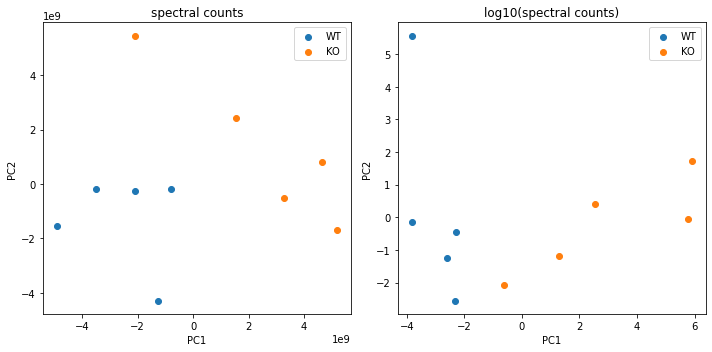

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)
samples = ['WT1', 'KOg15', 'KOg22', 'WT2', 'WT3', 'KOg21', 'KOg12', 'WT4', 'WT5', 'KOg11']
fig, axs = plt.subplots(1, 2)
for formatstring, ax in zip(['{}', 'log10({})'], axs):
    raw_value_cols = [formatstring.format(sample) for sample in samples]
    df = proteomics.loc[:, ['Genes'] + raw_value_cols].groupby('Genes').agg('max') # aggregate again
    df = df.loc[~df.isna().any(axis = 1), :] # remove nan values
    transform = pca.fit_transform(
        df.values.T
    )
    for sampletype in ['WT', 'KO']:
        ax.scatter(
            transform[df.columns.str.contains(sampletype), 0],
            transform[df.columns.str.contains(sampletype), 1],
            label = sampletype
        )
    ax.legend()
    ax.set_title(formatstring.format('spectral counts'))
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')

fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()

In [35]:
proteomics[proteomics.isna().any(axis = 1)]

,id,Common Names,Leading protein IDs,Protein IDs,Names,Genes,Gene names,log10(WT1),log10(KOg15),log10(KOg22),...,WT1,KOg15,KOg22,WT2,WT3,KOg21,KOg12,WT4,WT5,KOg11
218,1399,Protein kinase C beta type,P68404,P68404,KPCB,Prkcb,Prkcb,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,4740,Vesicle-associated membrane protein 3,P63024,P63024,VAMP3,Vamp3,Vamp3,6.429869,6.4354,6.508083,...,2.690723e+06,2.725208e+06,3.221688e+06,2.595402e+06,2.550523e+06,NaN,893324.934104,2.087966e+06,2.046852e+06,1.349723e+06
1057,5535,Protein chibby homolog 1,Q9D1C2,Q9D1C2,CBY1,Cby1,Cby1,6.067475,NaN,6.138965,...,1.168085e+06,NaN,1.377100e+06,1.163463e+06,1.161372e+06,1.143727e+06,873388.903777,1.302909e+06,1.201362e+06,6.059515e+05
1300,6549,Leucine-rich repeat-containing protein 4C,Q8C031,Q8C031,LRC4C,Lrrc4c,Lrrc4c,4.881696,NaN,NaN,...,7.615462e+04,NaN,NaN,1.172835e+05,1.031303e+05,6.692663e+05,86507.072055,9.272364e+04,9.538693e+04,2.012000e+05
1344,6635,Dual-specificity phosphatase 16,Q6PCP3,Q6PCP3,Q6PCP3,Dusp16,Dusp16,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38005,8262,Folliculin-interacting protein 2;Folliculin-in...,D3YUC5;Q80TD3,Q80TD3,D3YUC5;FNIP2,Fnip2,Fnip2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38076,8315,Thiamin pyrophosphokinase 1;Thiamin pyrophosph...,Q9R0M5;Q9R0M5-2;Q9R0M5-3,Q9R0M5,TPK1;TPK1;TPK1,Tpk1,Tpk1,4.856703,NaN,NaN,...,7.189578e+04,NaN,NaN,7.781051e+04,7.127140e+04,3.373063e+05,97085.490473,1.467787e+05,8.063904e+04,1.595414e+05
38211,8383,Ribosomal RNA-processing protein 7 homolog A (...,E9PYF0;E9QAX0;Q9D1C9,Q9D1C9,E9PYF0;E9QAX0;RRP7A,Rrp7a,Rrp7a,4.959907,NaN,NaN,...,9.118164e+04,NaN,NaN,7.735733e+04,7.883829e+04,1.755529e+05,120353.861783,7.938110e+04,8.368304e+04,1.040119e+05
38308,8427,"28S ribosomal protein S14, mitochondrial;28S r...",D3Z2K2;Q9CR88,D3Z2K2,D3Z2K2;RT14,Mrps14,Mrps14,4.867015,NaN,NaN,...,7.362320e+04,NaN,NaN,1.113295e+05,1.179124e+05,NaN,67350.984440,5.975999e+04,9.918420e+04,1.118958e+05


In [36]:
wt = proteomics.loc[:, proteomics.columns[proteomics.columns.str.startswith('WT')].to_list()]
wt = wt.loc[~(wt.isna().sum(axis = 1) > 2), :]
ko = proteomics.loc[:, proteomics.columns[proteomics.columns.str.startswith('KO')].to_list()]
ko = ko.loc[~(ko.isna().sum(axis = 1) > 2), :]
lfc_prot = pd.DataFrame(
    {
        'UniprotKB': proteomics['Protein IDs'],
        'genesymbol': proteomics['Genes'],
        'lfc_prot': np.log2(
            ko.apply(np.nanmean, axis = 1) / 
            wt.apply(np.nanmean, axis = 1)
        )
    }
)
lfc_prot

,UniprotKB,genesymbol,lfc_prot
5,Q01853,Vcp,-0.232761
7,P58252,Eef2,0.094301
8,P38647,Hspa9,-0.086990
10,P20029,Hspa5,-0.300102
13,Q9ERU9,Ranbp2,0.104234
...,...,...,...
38298,E9QKD9,Gtf2h1,1.285468
38299,G3X8R4,Gtf2h1,1.285468
38300,Q9DBA9,Gtf2h1,1.285468
38308,D3Z2K2,Mrps14,NaN


In [37]:
lfc = lfc.merge(
    lfc_prot.loc[:, ['UniprotKB', 'lfc_prot']],
    how = 'left',
    on = 'UniprotKB'
)
lfc

,genesymbol,lfc_rna,ncbi_id,UniprotKB,lfc_prot
0,Mrpl15,-0.626928,27395,Q9CPR5,0.715620
1,Mrpl15,-0.626928,27395,A0A0A6YVP4,0.715620
2,Lypla1,0.115159,18777,P97823,0.876329
3,Atp6v1h,0.418955,108664,Q8BVE3,-0.027147
4,Atp6v1h,0.418955,108664,A0A0A6YX18,-0.027147
...,...,...,...,...,...
5967,Hccs,-0.290481,15159,Q8BP79,NaN
5968,Mid1,-0.303377,17318,O70583,0.581499
5969,Mid1,-0.303377,17318,B1AV01,0.581499
5970,Mid1,-0.303377,17318,Q3TVH5,NaN


In [38]:
selections

{'(P2, WT) / (E14_5, WT)':         mapid                                               name foldchange
 0    mmu00230           Purine metabolism - Mus musculus (mouse)       0.86
 1    mmu01040  Biosynthesis of unsaturated fatty acids - Mus ...      1.275
 2    mmu04022  cGMP-PKG signaling pathway - Mus musculus (mouse)       1.99
 3    mmu00030   Pentose phosphate pathway - Mus musculus (mouse)       1.64
 4    mmu00240       Pyrimidine metabolism - Mus musculus (mouse)      -0.08
 ..        ...                                                ...        ...
 120    C00072                                      Ascorbic acid       0.55
 121    C00127                             L-Glutathione oxidized      -0.05
 122    C00005                                              NADPH      -3.00
 123    C00519                                        Hypotaurine      -1.73
 124    C05122                                   Taurocholic acid       3.80
 
 [125 rows x 3 columns],
 '(P40, WT) / (P2, WT)'

In [39]:
from functools import reduce
def make_union(a, b):
    return a.union(b)

selection_union = reduce(
    make_union,
    [set(d.mapid) for d in selections.values()]
)

In [40]:
geneids = get_pathway_genes(
    {k: selected_pathways[k] for k in [s for s in selection_union if s.startswith('mmu')]}
)

geneids

,ncbi_id,genesymbol
0,11656,Alas2
1,11655,Alas1
2,67417,Ears2
3,107508,Eprs
4,17025,Alad
...,...,...
2240,171210,Acot2
2241,171281,Acot3
2242,217698,Acot5
2243,171282,Acot4


In [41]:
# enzymes = lfc.loc[lfc.ec_number.isin(ec_numbers), ['ec_number', 'lfc']]
# enzymes.rename(
#     columns = {'ec_number': 'mapid'},
#     inplace = True
# )
# # prepend prefix required by iPATH
# enzymes.loc[:, 'mapid'] = enzymes.mapid.apply(
#     lambda x: 'EC' + x
# )
# enzymes
genes = lfc.loc[lfc.ncbi_id.isin(geneids.ncbi_id), ['UniprotKB', 'lfc_rna']].drop_duplicates()
genes.rename(
    columns = {'UniprotKB': 'mapid', 'lfc_rna': 'lfc'},
    inplace = True
)
# prepend prefix required by iPATH
genes.loc[:, 'mapid'] = genes.mapid.apply(
    lambda x: 'UNIPROT:' + x
)
genes

,mapid,lfc
2,UNIPROT:P97823,0.115159
3,UNIPROT:Q8BVE3,0.418955
4,UNIPROT:A0A0A6YX18,0.418955
5,UNIPROT:P33534,5.720830
6,UNIPROT:A0A5F8MP90,5.720830
...,...,...
5951,UNIPROT:P97355,-0.364524
5959,UNIPROT:P70303,0.396960
5965,UNIPROT:Q9CS42,-2.201418
5966,UNIPROT:P53702,-0.290481


In [42]:
compounds = metabo.loc[
    metabo.KEGG.isin([s for s in selection_union if s.startswith('C')]),
    ['KEGG', '(P2, KO) / (P2, WT)']
]
compounds.rename(
    columns = {
        'KEGG': 'mapid',
        '(P2, KO) / (P2, WT)': 'lfc'
    },
    inplace = True
)
compounds

,mapid,lfc
0,C00022,-0.31
1,C00041,-0.05
3,C00213,0.04
5,C00186,0.21
6,C00116,-0.06
...,...,...
232,C16527,0.24
234,C01083,0.60
237,C00015,-0.04
238,C00008,-0.19


In [43]:
integrated_selection = pd.concat(
    #[enzymes, compounds]
    [genes, compounds]
)
integrated_selection

,mapid,lfc
2,UNIPROT:P97823,0.115159
3,UNIPROT:Q8BVE3,0.418955
4,UNIPROT:A0A0A6YX18,0.418955
5,UNIPROT:P33534,5.72083
6,UNIPROT:A0A5F8MP90,5.72083
...,...,...
232,C16527,0.24
234,C01083,0.60
237,C00015,-0.04
238,C00008,-0.19


In [46]:
prefix = '../raw/ipath_selection_hilic'
suffix = 'P2_KO_WT_integrated'
ipath_selection = get_ipath_selection(
    integrated_selection,
    'lfc',
    'mapid',
    {'C': 15, 'UNIPROT': 10},
    vmin = -2,
    vmax = 2,
    cmap = coolwarm
)
ipath_selection.to_csv(
    '_'.join([prefix, suffix]) + '.tsv',
    sep = '\t',
    header = False,
    index = False
)

vmin = -2, vmax = 2


In [44]:
# same for proteomics
genes = lfc.loc[lfc.ncbi_id.isin(geneids.ncbi_id), ['UniprotKB', 'lfc_prot']].drop_duplicates()
genes.rename(
    columns = {'UniprotKB': 'mapid', 'lfc_prot': 'lfc'},
    inplace = True
)
# prepend prefix required by iPATH
genes.loc[:, 'mapid'] = genes.mapid.apply(
    lambda x: 'UNIPROT:' + x
)
genes

,mapid,lfc
2,UNIPROT:P97823,0.876329
3,UNIPROT:Q8BVE3,-0.027147
4,UNIPROT:A0A0A6YX18,-0.027147
5,UNIPROT:P33534,NaN
6,UNIPROT:A0A5F8MP90,NaN
...,...,...
5951,UNIPROT:P97355,0.063250
5959,UNIPROT:P70303,0.188956
5965,UNIPROT:Q9CS42,0.337636
5966,UNIPROT:P53702,0.271054


In [45]:
genes = genes.loc[~genes.lfc.isna(), :]
integrated_selection = pd.concat(
    #[enzymes, compounds]
    [genes, compounds]
)
integrated_selection

,mapid,lfc
2,UNIPROT:P97823,0.876329
3,UNIPROT:Q8BVE3,-0.027147
4,UNIPROT:A0A0A6YX18,-0.027147
29,UNIPROT:Q9D881,0.170296
30,UNIPROT:Q9EPW0,0.396988
...,...,...
232,C16527,0.24
234,C01083,0.60
237,C00015,-0.04
238,C00008,-0.19


In [46]:
prefix = '../raw/ipath_selection_hilic'
suffix = 'P2_KO_WT_integrated_proteomics'
ipath_selection = get_ipath_selection(
    integrated_selection,
    'lfc',
    'mapid',
    {'C': 15, 'UNIPROT': 10},
    vmin = -2,
    vmax = 2,
    cmap = coolwarm
)
ipath_selection.to_csv(
    '_'.join([prefix, suffix]) + '.tsv',
    sep = '\t',
    header = False,
    index = False
)

vmin = -2, vmax = 2


## Time series integration (mature neurons)

In [46]:
import scanpy as sc
adata = sc.read_h5ad(
    '../data/mouse_brain_development.h5ad'
)
adata.obs.groupby(['class_label', 'developmental_stage']).count()

subclass_label
class_label            developmental_stage                
GABAergic              Adult                          4053
                       E14.5                           119
                       P4                              882
Immature Glutamatergic Adult                             0
                       E14.5                          1284
                       P4                              912
Mature Glutamatergic   Adult                         74263
                       E14.5                           632
                       P4                             3340
Non-Neuronal           Adult                          2199
                       E14.5                             0
                       P4                             1089
Progenitors            Adult                             0
                       E14.5                          1058
                       P4                                0

In [47]:
import numpy as np
import anndata as ad

# subsampling of cells to balance cell counts
adatas = dict()
for class_label, group in adata.obs.groupby('class_label'):
    #min_cell_count = group.groupby('developmental_stage').count().class_label.min()
    
    # sample cells
    #if min_cell_count > 0:
    if class_label in ['GABAergic', 'Mature Glutamatergic']:
        adatas[class_label] = []
        for devstage in ['E14.5', 'P4', 'Adult']:
#             cells = np.random.choice(
#                 adata.obs.loc[(adata.obs.developmental_stage == devstage) & (adata.obs.class_label == class_label), :].index.to_list(),
#                 size = min_cell_count,
#                 replace = False
#             )
            adatas[class_label].append(
                #adata[cells, :].copy()
                adata[(adata.obs.developmental_stage == devstage) & (adata.obs.class_label == class_label), :].copy()
            )
        
        adatas[class_label] = ad.concat(adatas[class_label])

adatas

{'GABAergic': AnnData object with n_obs × n_vars = 5054 × 26589
     obs: 'class_label', 'subclass_label', 'developmental_stage',
 'Mature Glutamatergic': AnnData object with n_obs × n_vars = 78235 × 26589
     obs: 'class_label', 'subclass_label', 'developmental_stage'}

In [48]:
lfcs = dict()
for cell_class, cell_adata in adatas.items():
    cell_adata = cell_adata.copy()
    sc.pp.normalize_total(cell_adata, target_sum = 1e4)
    lfcs[cell_class] = dict()
    for dev1, dev2 in [('E14.5', 'P4'), ('P4', 'Adult')]:
        dev1means = np.array(cell_adata[cell_adata.obs.developmental_stage == dev1, :].X.mean(axis = 0))[0]
        dev2means = np.array(cell_adata[cell_adata.obs.developmental_stage == dev2, :].X.mean(axis = 0))[0]
        lfc = pd.DataFrame(
            {
                'genesymbol': cell_adata.var.index,
                'lfc_rna': np.log2(dev2means/dev1means)
            }
        )
        lfc = lfc[~lfc.lfc_rna.isna() & ~np.isinf(lfc.lfc_rna)]
        lfcs[cell_class][f'{dev2}/{dev1}'] = lfc
lfcs

/tmp/ipykernel_4353/1490354668.py:12: RuntimeWarning: divide by zero encountered in true_divide
  'lfc_rna': np.log2(dev2means/dev1means)
/tmp/ipykernel_4353/1490354668.py:12: RuntimeWarning: invalid value encountered in true_divide
  'lfc_rna': np.log2(dev2means/dev1means)
/tmp/ipykernel_4353/1490354668.py:12: RuntimeWarning: divide by zero encountered in log2
  'lfc_rna': np.log2(dev2means/dev1means)


{'GABAergic': {'P4/E14.5':        genesymbol   lfc_rna
  0            Xkr4  0.031112
  6          Mrpl15  0.124683
  7          Lypla1  0.434873
  9           Tcea1 -0.658329
  10          Rgs20  1.937063
  ...           ...       ...
  26521      mt-Nd5  0.125783
  26522      mt-Nd6  0.919818
  26523     mt-Cytb  0.431486
  26536       Vamp7  0.471301
  26586  AC168977.1 -4.373901
  
  [10792 rows x 2 columns],
  'Adult/P4':        genesymbol   lfc_rna
  0            Xkr4  7.593171
  6          Mrpl15 -2.283272
  7          Lypla1 -8.018593
  9           Tcea1 -1.488320
  10          Rgs20  3.192369
  ...           ...       ...
  26523     mt-Cytb -0.550597
  26536       Vamp7 -0.719773
  26538       Spry3  3.672767
  26539       Tmlhe  6.424846
  26586  AC168977.1 -0.178581
  
  [14062 rows x 2 columns]},
 'Mature Glutamatergic': {'P4/E14.5':        genesymbol   lfc_rna
  0            Xkr4  1.992114
  4           Sox17 -3.239237
  6          Mrpl15 -0.306471
  7          Lypla1  0.1

In [49]:
metabo.columns

Index(['ID', 'Name', 'Calc. MW', 'RT [min]', '(P40, KO) / (P40, WT)',
       '(P2, KO) / (P2, WT)', '(E14_5, KO) / (E14_5, WT)',
       '(P40, WT) / (P2, WT)', '(P40, WT) / (E14_5, WT)',
       '(P2, WT) / (E14_5, WT)', '(P40, KO) / (P2, KO)',
       '(P40, KO) / (E14_5, KO)', '(P2, KO) / (E14_5, KO)',
       '(P40, KO) / (P40, WT).1', '(P2, KO) / (P2, WT).1',
       '(E14_5, KO) / (E14_5, WT).1', '(P40, WT) / (P2, WT).1',
       '(P40, WT) / (E14_5, WT).1', '(P2, WT) / (E14_5, WT).1',
       '(P40, KO) / (P2, KO).1', '(P40, KO) / (E14_5, KO).1',
       '(P2, KO) / (E14_5, KO).1', 'S01_P40_WT1', 'S02_P40_KO1', 'S03_P40_WT2',
       'S04_P40_KO2', 'S05_P40_WT3', 'S06_P40_KO3', 'S07_P40_WT4',
       'S08_P40_KO4', 'S09_P2_WT1', 'S10_P2_KO1', 'S11_P2_WT2', 'S12_P2_KO2',
       'S13_P2_WT3', 'S14_P2_KO3', 'S15_P2_WT4', 'S16_P2_KO4', 'S17_E14_5_WT1',
       'S18_E14_5_KO1', 'S19_E14_5_WT2', 'S20_E14_5_KO2', 'S21_E14_5_WT3',
       'S22_E14_5_KO3', 'S23_E14_5_WT4', 'S24_E14_5_KO4', 'blank01'

In [50]:
entrez_to_uniprot.loc[:, 'ncbi_id'] = entrez_to_uniprot.ncbi_id.astype(str)
integrated_selections = dict()
for cell_label in ['GABAergic', 'Mature Glutamatergic']:
    integrated_selections[cell_label] = []
    for lfc_label, metabo_label, suffix_label in zip(
        ['P4/E14.5', 'Adult/P4'],
        ['(P2, WT) / (E14_5, WT)', '(P40, WT) / (P2, WT)'],
        ['P4_E14_5', 'Adult_P4']
    ):
        compounds = metabo.loc[
            metabo.KEGG.isin([s for s in selection_union if s.startswith('C')]),
            ['KEGG', metabo_label]
        ]
        compounds.rename(
            columns = {
                'KEGG': 'mapid',
                metabo_label: 'lfc'
            },
            inplace = True
        )
        
        lfc = lfcs[cell_label][lfc_label]
        lfc = lfc.merge(
            pathway_genes,
            how = 'inner',
            on = 'genesymbol'
        )
        lfc = lfc.merge(
            entrez_to_uniprot,
            how = 'inner',
            on = 'ncbi_id'
        )

        genes = lfc.loc[lfc.ncbi_id.isin(geneids.ncbi_id), ['UniprotKB', 'lfc_rna']].drop_duplicates()
        genes.rename(
            columns = {'UniprotKB': 'mapid', 'lfc_rna': 'lfc'},
            inplace = True
        )
        # prepend prefix required by iPATH
        genes.loc[:, 'mapid'] = genes.mapid.apply(
            lambda x: 'UNIPROT:' + x
        )

        genes = genes.loc[~genes.lfc.isna(), :]
        integrated_selection = pd.concat(
            #[enzymes, compounds]
            [genes, compounds]
        )
        
        integrated_selections[cell_label].append(
            integrated_selection
        )
        
        prefix = '../raw/ipath_selection_hilic'
        if cell_label == 'Mature Glutamatergic':
            suffix = f'{suffix_label}_Glutamatergic_timeseries'
            
        else:
            suffix = f'{suffix_label}_{cell_label}_timeseries'
            
        ipath_selection = get_ipath_selection(
            integrated_selection,
            'lfc',
            'mapid',
            {'C': 15, 'UNIPROT': 10},
            vmin = -2,
            vmax = 2,
            cmap = coolwarm
        )
        ipath_selection.to_csv(
            '_'.join([prefix, suffix]) + '.tsv',
            sep = '\t',
            header = False,
            index = False
        )

vmin = -2, vmax = 2
vmin = -2, vmax = 2
vmin = -2, vmax = 2
vmin = -2, vmax = 2


In [59]:
pd.concat(integrated_selections['GABAergic']).drop_duplicates(subset = 'mapid')

,mapid,lfc
2,UNIPROT:P97823,-0.038097
3,UNIPROT:Q8BVE3,-0.418271
4,UNIPROT:A0A0A6YX18,-0.418271
24,UNIPROT:Q9D881,1.10507
25,UNIPROT:Q9EPW0,1.173335
...,...,...
5354,UNIPROT:B6VJS3,4.416538
5371,UNIPROT:P13516,-2.050448
5372,UNIPROT:Q547C4,-2.050448
5384,UNIPROT:Q01338,2.465348


In [95]:
prefix = '../raw/ipath_selection_hilic_base'
for cell_label in ['GABAergic', 'Mature Glutamatergic']:
    ipath_selection = get_ipath_selection(
        pd.concat(integrated_selections[cell_label]).drop_duplicates(subset = 'mapid'),
        'lfc',
        'mapid',
        {'C': 15, 'UNIPROT': 10},
        color = '#dddddd'
    )
    suffix = cell_label if cell_label == 'GABAergic' else 'Glutamatergic'
    ipath_selection.to_csv(
        '_'.join([prefix, suffix]) + '.tsv',
        sep = '\t',
        header = False,
        index = False
    )

## Time series integration (immature to mature)

In [22]:
import scanpy as sc
adata = sc.read_h5ad(
    '../data/mouse_brain_development.h5ad'
)
adata.obs.groupby(['class_label', 'developmental_stage']).count()

subclass_label
class_label            developmental_stage                
GABAergic              Adult                          4053
                       E14.5                           119
                       P4                              882
Immature Glutamatergic Adult                             0
                       E14.5                          1284
                       P4                              912
Mature Glutamatergic   Adult                         74263
                       E14.5                           632
                       P4                             3340
Non-Neuronal           Adult                          2199
                       E14.5                             0
                       P4                             1089
Progenitors            Adult                             0
                       E14.5                          1058
                       P4                                0

In [23]:
import numpy as np
immature = adata[(adata.obs.developmental_stage == 'E14.5') & (adata.obs.class_label == 'Immature Glutamatergic'), :].copy()
p4_mature = adata[(adata.obs.developmental_stage == 'P4') & (adata.obs.class_label == 'Mature Glutamatergic'), :].copy()
# subsample 1000 cells
adult_mature = adata[(adata.obs.developmental_stage == 'Adult') & (adata.obs.class_label == 'Mature Glutamatergic'), :].copy()

In [34]:
adult_mature

AnnData object with n_obs × n_vars = 74263 × 26589
    obs: 'class_label', 'subclass_label', 'developmental_stage'

In [24]:
lfcs = dict()
sc.pp.normalize_total(immature, target_sum = 1e4)
sc.pp.normalize_total(p4_mature, target_sum = 1e4)
sc.pp.normalize_total(adult_mature, target_sum = 1e4)
immature_means = np.array(immature.X.mean(axis = 0))[0]
p4_mature_means = np.array(p4_mature.X.mean(axis = 0))[0]
adult_mature_means = np.array(adult_mature.X.mean(axis = 0))[0]
for (dev1means, dev2means), (label1, label2) in zip(
    [(immature_means, p4_mature_means), (p4_mature_means, adult_mature_means)],
    [('immature', 'p4_mature'), ('p4_mature', 'adult_mature')]
):
    lfc = pd.DataFrame(
        {
            'genesymbol': immature.var.index,
            'lfc_rna': np.log2(dev2means/dev1means)
        }
    )
    lfc = lfc[~lfc.lfc_rna.isna() & ~np.isinf(lfc.lfc_rna)]
    lfcs[f'{label2}/{label1}'] = lfc
lfcs

/tmp/ipykernel_22158/1724943034.py:15: RuntimeWarning: divide by zero encountered in true_divide
  'lfc_rna': np.log2(dev2means/dev1means)
/tmp/ipykernel_22158/1724943034.py:15: RuntimeWarning: invalid value encountered in true_divide
  'lfc_rna': np.log2(dev2means/dev1means)
/tmp/ipykernel_22158/1724943034.py:15: RuntimeWarning: divide by zero encountered in log2
  'lfc_rna': np.log2(dev2means/dev1means)


{'p4_mature/immature':        genesymbol   lfc_rna
 0            Xkr4  4.899180
 6          Mrpl15 -0.520136
 7          Lypla1 -0.662573
 9           Tcea1 -0.472759
 10          Rgs20  3.030723
 ...           ...       ...
 26523     mt-Cytb  0.596767
 26536       Vamp7  0.200232
 26538       Spry3 -0.235366
 26555  AC132444.1 -0.723605
 26586  AC168977.1  0.807058
 
 [13531 rows x 2 columns],
 'adult_mature/p4_mature':        genesymbol   lfc_rna
 0            Xkr4  7.633498
 4           Sox17  1.344600
 6          Mrpl15 -2.110187
 7          Lypla1 -8.413507
 9           Tcea1 -1.522540
 ...           ...       ...
 26523     mt-Cytb -1.115231
 26536       Vamp7 -1.051003
 26538       Spry3  1.991526
 26555  AC132444.1 -0.843406
 26586  AC168977.1 -4.325497
 
 [16079 rows x 2 columns]}

In [25]:
entrez_to_uniprot.loc[:, 'ncbi_id'] = entrez_to_uniprot.ncbi_id.astype(str)
integrated_selections = []
for lfc_label, metabo_label, suffix_label in zip(
    ['p4_mature/immature', 'adult_mature/p4_mature'],
    ['(P2, WT) / (E14_5, WT)', '(P40, WT) / (P2, WT)'],
    ['P4mature_E14_5immature', 'Adultmature_P4mature']
):
    compounds = metabo.loc[
        metabo.KEGG.isin([s for s in selection_union if s.startswith('C')]),
        ['KEGG', metabo_label]
    ]
    compounds.rename(
        columns = {
            'KEGG': 'mapid',
            metabo_label: 'lfc'
        },
        inplace = True
    )

    lfc = lfcs[lfc_label]
    lfc = lfc.merge(
        pathway_genes,
        how = 'inner',
        on = 'genesymbol'
    )
    lfc = lfc.merge(
        entrez_to_uniprot,
        how = 'inner',
        on = 'ncbi_id'
    )

    genes = lfc.loc[lfc.ncbi_id.isin(geneids.ncbi_id), ['UniprotKB', 'lfc_rna']].drop_duplicates()
    genes.rename(
        columns = {'UniprotKB': 'mapid', 'lfc_rna': 'lfc'},
        inplace = True
    )
    # prepend prefix required by iPATH
    genes.loc[:, 'mapid'] = genes.mapid.apply(
        lambda x: 'UNIPROT:' + x
    )

    genes = genes.loc[~genes.lfc.isna(), :]
    integrated_selection = pd.concat(
        #[enzymes, compounds]
        [genes, compounds]
    )

    integrated_selections.append(
        integrated_selection
    )

    prefix = '../raw/ipath_selection_hilic_Glutamatergic_development'

    ipath_selection = get_ipath_selection(
        integrated_selection,
        'lfc',
        'mapid',
        {'C': 15, 'UNIPROT': 10},
        vmin = -2,
        vmax = 2,
        cmap = coolwarm
    )
    ipath_selection.to_csv(
        '_'.join([prefix, suffix_label]) + '.tsv',
        sep = '\t',
        header = False,
        index = False
    )

vmin = -2, vmax = 2
vmin = -2, vmax = 2


In [34]:
prefix = '../raw/ipath_selection_hilic_base'
ipath_selection = get_ipath_selection(
    pd.concat(integrated_selections).drop_duplicates(subset = 'mapid'),
    'lfc',
    'mapid',
    {'C': 15, 'UNIPROT': 10},
    color = '#dddddd'
)
ipath_selection.to_csv(
    '_'.join([prefix, 'Glutamatergic_development']) + '.tsv',
    sep = '\t',
    header = False,
    index = False
)